In [1]:
import pyemma
import pickle
import numpy as np
from msmbuilder.utils import load,dump

%matplotlib inline
import matplotlib.pyplot as plt

/home/bhakat/anaconda3/envs/msmbuilder/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)

Bad key "text.kerning_factor" on line 4 in
/home/bhakat/anaconda3/envs/msmbuilder/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
with open('raw-features.pkl', 'rb') as f:
     features = pickle.load(f)

In [3]:
with open('features.pkl', 'rb') as a:
     transfeatures = pickle.load(a)

In [4]:
transfeatures[0].shape

(20001, 4)

In [5]:
with open('scaled-transformed-features.pkl', 'rb') as b:
     scaletransfeatures = pickle.load(b)

In [6]:
#cocatenate features
features_concatenated = np.concatenate(features)

In [7]:
#cocatenate transformed features
transfeatures_concatenated = np.concatenate(transfeatures)

In [8]:
#cocatenate scaled features
scaletransfeatures_concatenated = np.concatenate(scaletransfeatures)

In [9]:
cluster = pyemma.coordinates.cluster_kmeans(transfeatures, k=500, max_iter=250, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

100%|██████████| 500/500 [10:24<00:00,  1.25s/it]                             

100%|██████████| 32/32 [00:02<00:00, 13.89it/s]                                    


100%|██████████| 6/6 [00:26<00:00,  4.35s/it]                                 


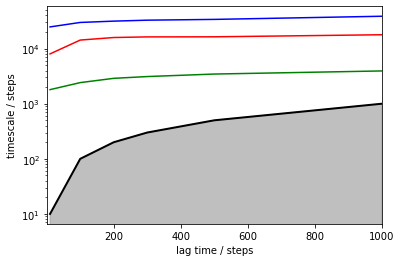

In [10]:
its = pyemma.msm.its(cluster.dtrajs, lags=[10, 100, 200, 300, 500, 1000], nits=3)
pyemma.plots.plot_implied_timescales(its);

In [10]:
lag = 200
#framesperns = 10
#msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=100, dt_traj='0.1 ns')
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag)

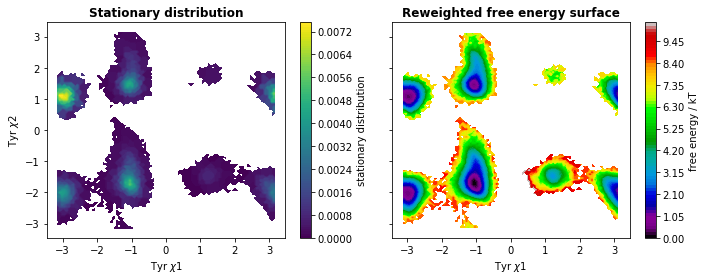

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *features_concatenated[:, :2].T,
    msm.pi[np.concatenate(msm.dtrajs_active)],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *features_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('Tyr $\chi1$')
axes[0].set_ylabel('Tyr $\chi2$')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

In [11]:
nstates = 5
msm.pcca(nstates)

PCCA(P=array([[0.0086 , 0.     , ..., 0.     , 0.     ],
       [0.     , 0.02575, ..., 0.     , 0.00033],
       ...,
       [0.     , 0.     , ..., 0.0075 , 0.00184],
       [0.     , 0.00018, ..., 0.00015, 0.02521]]),
   m=5)

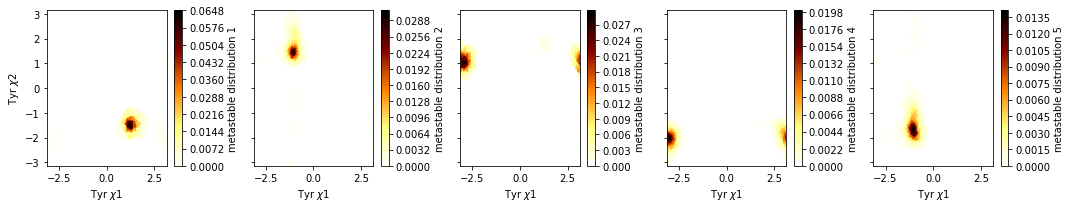

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *features_concatenated[:, :2].T,
        msm.metastable_distributions[i][np.concatenate(msm.dtrajs_active)],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('Tyr $\chi1$')
axes[0].set_ylabel('Tyr $\chi2$')
fig.tight_layout()

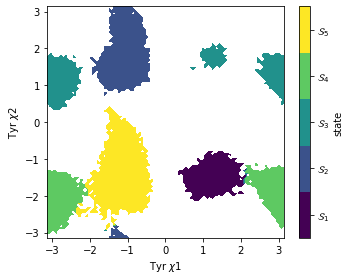

In [13]:
metastable_traj = msm.metastable_assignments[np.concatenate(msm.dtrajs_active)]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *features_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('Tyr $\chi1$')
ax.set_ylabel('Tyr $\chi2$')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()

In [16]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT ns')
DataFrame(np.round(mfpt * 20 /1000, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT ns


,1,2,3,4,5
1,0.00,933.42,2578.42,185.23,606.26
2,4048.76,0.00,1881.06,1756.83,222.38
3,4576.07,758.54,0.00,2265.66,869.94
4,2453.30,955.10,2588.47,0.00,631.77
5,3867.81,365.96,2131.64,1581.23,0.00


## Normal to Flip trabnsition time

### State 5 to state 4

In [15]:
state5 = msm.metastable_sets[4]
state4 = msm.metastable_sets[3]

In [22]:
print('MFPT in ns')

MFPT in ns


In [17]:
msm.mfpt(state5, state4) * 20 /1000 # in ns

1574.8574875412228

### State 4 to state 5

In [23]:
msm.mfpt(state4, state5) * 20 /1000 # in ns

632.9345407304991

### State 2 to state 3

In [18]:
state2 = msm.metastable_sets[1]
state3 = msm.metastable_sets[2]

In [19]:
msm.mfpt(state2, state3) * 20 /1000 # in ns

1881.2225165012055

### State 3 to state 2

In [24]:
msm.mfpt(state3, state2) * 20 /1000 # in ns

757.761462838768